In [1]:
import pyvisa
import numpy as np
import time
import pandas as pd
import os
import sys
import CVCommands
import JVfunctions
from os import path
from simple_pid import PID
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from scipy import signal
from datetime import datetime
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from pyvisa import ResourceManager, constants
from usb.core import find as finddev
from IPython.display import clear_output

JVfunctions Loaded Without Error


In [6]:
sampName = 'test'
cellNum = '001'

Vmin = -.3
Vmax = .7

acfreq = 1e6
dcfreq = 1

amp = 0.05

num_avg = 1 #Number of measurements to average

delay = .1 #Delay between changing to new value

#Measurement time = cycles / dcfreq

dmm_cycles = 40 #Number of waveforms to measure for the voltage fit

lcr_cycles = 40 #Number of waveforms to measure for the LCR

fit_floorceil = False
####################################################

#PID tuning parameters for V setpoint
Ku = 1.3
Tu = 1
CVCommands.P = 0.45*Ku    #3.06
CVCommands.I = 0.54*Ku/Tu    #2.8
CVCommands.D = 0.0

CVCommands.offset = 0.005 #Acceptable tolerance for voltage setpoint in V

CVCommands.reset_i = 0 #Subtract this value from voltage setpoint to improve PID speed
CVCommands.reset = 5 #Subtract value from setpoint after reset trigger

CVCommands.reset_val = 1000 #Trigger voltage setpoint reset after iterations
CVCommands.shutoff_val = 1000 #Max iterations before shutdown
CVCommands.num_avg = num_avg
CVCommands.mvavg_num = 20 #Number of points to calculate voltage setpoint moving average

CVCommands.v_ceiling = 35 #Max allowable voltage sent to SMU, maximum value 35

CVCommands.trig_delay = 0
CVCommands.meas_speed = 'FAST' #FAST, MED, SLOW, SLOW2
CVCommands.lowz = 'OFF'

CVCommands.LCR_timeout = 60*1000
CVCommands.check_fastCV_Vpp(Vmin, Vmax)

dmm_cycle_time = dmm_cycles/dcfreq
lcr_cycle_time = lcr_cycles/dcfreq

In [7]:
os.chdir('/home/pi/Desktop/CV')
foldname = datetime.today().strftime('%m-%d-%Y')
now = datetime.now()
currtime = now.strftime("%m%d%y%H%M")
month_format = datetime.today().strftime('%m-%Y')
currtime_format = now.strftime("%m/%d/%y %H:%M")

if os.path.isdir(month_format) is False:
    os.mkdir(month_format)
    os.chdir(month_format)
else:
    os.chdir(month_format)

if os.path.isdir(foldname) is False:
    os.mkdir(foldname)

os.chdir(foldname)

SMU, DMM, LCR, AFG = CVCommands.inst_connect(
    SMUon = True, DMMon = True, LCRon = True, AFGon = True)

CVCommands.sampName = sampName
CVCommands.LCR_configure()
CVCommands.LCR_CGD()

CVCommands.checkContact()

time.sleep(1)
################################################


Forward V check GOOD
Reverse V check GOOD


Calibrating Vmin/Vmax:   0%|          | 0/40 [00:00<?, ?it/s]

DMM sweep:   0%|          | 0/40.0 [00:00<?, ?it/s]

LCR sweep:   0%|          | 0/40.0 [00:00<?, ?it/s]

Raw V points


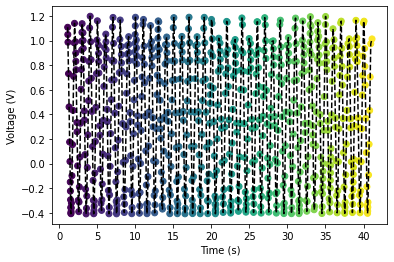

Raw V with fit


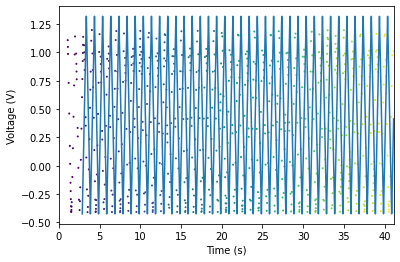

C vs. V


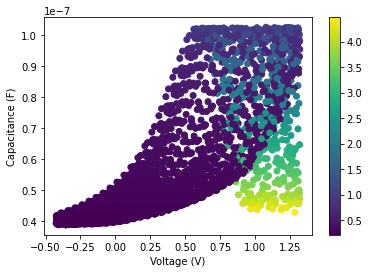

C vs. V, up-sweep only


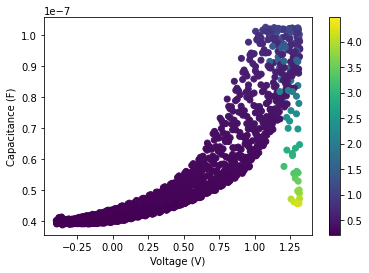

C vs. V, down-sweep only


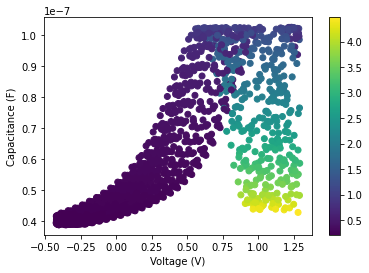

Saving as: test_ultrafast_CV_0714221636_1000kHz


In [242]:
try:
    print('Setting Vsmu max')
    CVCommands.setBias(Vmax, True, False)
    Vmax_smu = float(SMU.query(':SOUR:VOLT:LEV?'))
    if Vmax_smu > 5:
        Vmax_smu = 5

    print('Setting Vsmu min')
    CVCommands.setBias(Vmin, True, False)
    Vmin_smu = float(SMU.query(':SOUR:VOLT:LEV?'))
    if Vmin_smu < -5:
        Vmin_smu = -5
    CVCommands.offBias()


    Vpp = abs(Vmax_smu - Vmin_smu)

    V_offset = Vpp/2 + Vmin_smu

    AFG.write('SOURce1:VOLTage:LEVel:IMMediate:AMPLitude '+str(Vpp))
    AFG.write('SOURce1:VOLTage:LEVel:IMMediate:OFFS '+str(V_offset))
    AFG.write('SOURce1:FREQuency:FIXed '+str(dcfreq)+'Hz')


    CVCommands.setFreq(acfreq)
    CVCommands.set_oscVolt(amp)

    AFG.write('SOURce1:FUNCtion:SHAPe SQUARE')
    AFG.write('OUTPut1:STATe ON')

    V = []

    for i in tqdm(range(int(100/dcfreq)), desc = 'Calibrating Vmin/Vmax'):
        Vread = float(DMM.query(':READ?'))
        if Vread < 1e4:
            V.append(Vread)

    midpoint = (np.max(V) - np.min(V)) / 2

    Vmax_cap = np.median(np.array(V)[V > midpoint])
    Vmin_cap = np.median(np.array(V)[V < midpoint])

    AFG.write('OUTPut1:STATe OFF')

    Vpp_cap = abs(Vmax_cap - Vmin_cap)
    V_offset_cap = Vpp_cap/2 + Vmin_cap

    V = []
    C = []
    G = []
    D = []

    Tdmm = []
    Tlcr = []

    AFG.write('SOURce1:FUNCtion:SHAPe RAMP')
    AFG.write('OUTPut1:STATe ON')
    start_time = time.time()
    time.sleep(1)

    chk_time = time.time()


    with tqdm(total=dmm_cycle_time, desc = 'DMM sweep') as pbar:
        while True:
            Vread = float(DMM.query(':READ?'))

            if Vread < 1e4:
                V.append(Vread)
                Tdmm.append(time.time() - start_time)

            tot_time = time.time() - chk_time

            pstep = tot_time - pbar.n
            if pstep >= 1:
                pbar.update(pstep)

            if tot_time >= dmm_cycle_time:
                pbar.update(dmm_cycle_time - pbar.n)
                break

    chk_time = time.time()

    with tqdm(total=lcr_cycle_time, desc = 'LCR sweep') as pbar:
        while True:
            cget, gget, dget = CVCommands.getData()
            Tlcr.append(time.time()-start_time)

            C.append(cget)
            G.append(gget)
            D.append(dget)

            tot_time = time.time() - chk_time

            pstep = tot_time - pbar.n
            if pstep >= 1:
                pbar.update(pstep)

            if tot_time >= lcr_cycle_time:
                pbar.update(lcr_cycle_time - pbar.n)
                break


except:
    AFG.write('OUTPut1:STATe OFF')
    raise Exception("Error")

AFG.write('OUTPut1:STATe OFF')
T = Tdmm

print('Raw V points')
plt.scatter(T,V,c=T)
plt.plot(T,V,color='k',linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')

plt.show()

if fit_floorceil == True:
    Vpp_fit = Vpp
    V_offset_fit = V_offset
else:
    Vpp_fit = Vpp_cap
    V_offset_fit = V_offset_cap

t = np.linspace(0,np.max(Tlcr),(dmm_cycles+lcr_cycles)*1000)

#Vnew = np.interp(Tnew, T, V)

triangle = Vpp_fit/2*signal.sawtooth(2 * np.pi * dcfreq * t, 0.5) + V_offset_fit

def func(x, A):
    triangle = Vpp_fit/2*signal.sawtooth(2 * np.pi * dcfreq * x+A, 0.5) + V_offset_fit
    
    return triangle
    
offset, off_cov = curve_fit(func, T, V)

t = t + offset[0]

triangle[triangle > Vmax_cap] = Vmax_cap
triangle[triangle < Vmin_cap] = Vmin_cap

print('Raw V with fit')
plt.plot(t, triangle)
plt.scatter(T,V,c=T, s=1)
plt.xlim(0,Tdmm[-1])
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')

plt.show()

tnew = np.linspace(Tlcr[0], Tlcr[-1], len(C)) + offset[0] 
Vnew = np.interp(tnew, t, triangle)

up = []

for i in range(len(Vnew)):
    if Vnew[i] - Vnew[i-1] > 0:
        up.append(True)
    else:
        up.append(False)

tempdict = {
    'volt_V' : Vnew,
    'is_up' : up,
    'cap_F' : C,
    'cond_S' : G,
    'diss_D' : D,
    'time_s' : Tlcr,
}

info_labels = ['Sample Name: ','Cell Number: ','Vmin: ','Vmax: ','AC Freq: ','DC Freq: ','AC amp: ','Start time: ']
info_data = [sampName,cellNum,Vmin,Vmax,acfreq,dcfreq,amp,currtime_format]

dictlen = len(tempdict[list(tempdict.keys())[0]])
infolen = len(info_data)

if dictlen >= infolen:
    info_labels = info_labels+[np.nan]*(dictlen-infolen)
    info_data = info_data+[np.nan]*(dictlen-infolen)
else:
    for i in tempdict:
        tempdict[i] = tempdict[i]+[np.nan]*(infolen-dictlen)

tempdict['Info1'] = info_labels
tempdict['Info2'] = info_data

df = pd.DataFrame(tempdict)

print('C vs. V')
plt.scatter(df.volt_V[df.volt_V < max(df.volt_V)], df.cap_F[df.volt_V < max(df.volt_V)]
            , c = df.diss_D[df.volt_V < max(df.volt_V)], cmap = 'viridis'
            ,vmin = min(df.diss_D),vmax = max(df.diss_D))
plt.xlabel('Voltage (V)')
plt.ylabel('Capacitance (F)')
plt.colorbar()
plt.show()

print('C vs. V, up-sweep only')
plt.scatter(df.volt_V[df.is_up], df.cap_F[df.is_up], c = df.diss_D[df.is_up], cmap = 'viridis'
            ,vmin = min(df.diss_D),vmax = max(df.diss_D))
plt.xlabel('Voltage (V)')
plt.ylabel('Capacitance (F)')
plt.colorbar()
plt.show()

print('C vs. V, down-sweep only')
plt.scatter(df.volt_V[np.invert(df.is_up)], df.cap_F[np.invert(df.is_up)], c = df.diss_D[np.invert(df.is_up)]
            , cmap = 'viridis' ,vmin = min(df.diss_D),vmax = max(df.diss_D))
plt.xlabel('Voltage (V)')
plt.ylabel('Capacitance (F)')
plt.colorbar()
plt.show()

print('Saving as: '+''.join([sampName,'_ultrafast_CV','_',currtime,'_',"{:.0f}".format(acfreq/1000),'kHz']))
df.to_csv(''.join([sampName,'_ultrafast_CV','_',currtime,'_',"{:.0f}".format(acfreq/1000),'kHz']),sep='\t')

C vs. V, down-sweep only


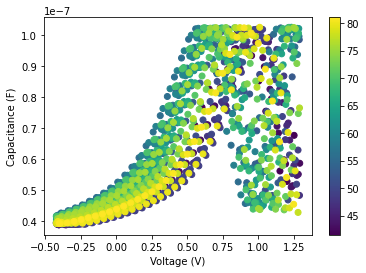

In [244]:
print('C vs. V, down-sweep only')
plt.scatter(df.volt_V[np.invert(df.is_up)], df.cap_F[np.invert(df.is_up)], c = df.time_s[np.invert(df.is_up)]
            , cmap = 'viridis' )
plt.xlabel('Voltage (V)')
plt.ylabel('Capacitance (F)')
plt.colorbar()
plt.show()